In [1]:
import tensorflow as tf
import numpy as np
import os
import csv
import matplotlib.pyplot as plt

In [2]:
def read_csv(file_path):
    time = []
    series = []
    with open(file_path) as f:
        reader = csv.reader(f)
        print(reader.__next__())
        for line in reader:
            time.append(int(line[0]))
            series.append(float(line[-1]))
        time = np.array(time)
        series = np.array(series, dtype=np.float32)
    return time, series

In [7]:
def tf_windowed_dataset(data, window_size, batch_size, shuffle_buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [13]:
file_path = './Sunspots.csv'
time, series = read_csv(file_path)
print(f'time length{time.shape}')
print(f'series length{series.shape}')
# plt.plot(time[200:500], series[200:500])
# plt.show()

['', 'Date', 'Monthly Mean Total Sunspot Number']
time length(3265,)
series length(3265,)


In [78]:
window_size = 30
batch_size  = 32
shuffle_buffer = 100
split_size = 2500 #.75

train_y = series[:split_size]
train_x = time[:split_size]

test_y = series[split_size:]
test_x = time[split_size:]

train_dataset = tf_windowed_dataset(train_y, window_size, batch_size, shuffle_buffer)
test_dataset = tf_windowed_dataset(test_y, window_size, batch_size, shuffle_buffer)

In [83]:
model = tf.keras.Sequential([
    # tf.keras.layers.Conv1D(32, 3, dilation_rate=3 ,padding='same', activation='relu',input_shape=[None, 1]),
    # tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True),input_shape=[None, 1]), # copy/remove the input shape here if you don't want to use Conv1D
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

print(model.summary())

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_26 (Bidirecti  (None, None, 64)         8704      
 onal)                                                           
                                                                 
 gru_7 (GRU)                 (None, 32)                9408      
                                                                 
 dense_46 (Dense)            (None, 16)                528       
                                                                 
 dense_47 (Dense)            (None, 1)                 17        
                                                                 
Total params: 18,657
Trainable params: 18,657
Non-trainable params: 0
_________________________________________________________________
None


In [84]:
loss = tf.keras.losses.Huber()
optim = tf.keras.optimizers.Adam(1e-3)
cb = tf.keras.metrics.MeanAbsoluteError(name='MAE')

model.compile(
    loss = loss,
    optimizer=optim,
    metrics=[cb]
)

In [85]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data= test_dataset
)

Epoch 1/100
78/78 [==============================] - 4s 19ms/step - loss: 72.2708 - MAE: 72.7676 - val_loss: 72.4084 - val_MAE: 72.9033
Epoch 2/100
78/78 [==============================] - 1s 9ms/step - loss: 62.1515 - MAE: 62.6467 - val_loss: 61.7559 - val_MAE: 62.2478
Epoch 3/100
78/78 [==============================] - 1s 9ms/step - loss: 51.2456 - MAE: 51.7397 - val_loss: 50.5408 - val_MAE: 51.0335
Epoch 4/100
78/78 [==============================] - 1s 9ms/step - loss: 40.4965 - MAE: 40.9908 - val_loss: 40.0949 - val_MAE: 40.5869
Epoch 5/100
78/78 [==============================] - 1s 9ms/step - loss: 32.3871 - MAE: 32.8799 - val_loss: 32.5961 - val_MAE: 33.0881
Epoch 6/100
78/78 [==============================] - 1s 9ms/step - loss: 27.8513 - MAE: 28.3420 - val_loss: 27.8413 - val_MAE: 28.3345
Epoch 7/100
78/78 [==============================] - 1s 9ms/step - loss: 25.3313 - MAE: 25.8234 - val_loss: 24.3386 - val_MAE: 24.8298
Epoch 8/100
78/78 [==============================] - 1

In [86]:
history.history.keys()

dict_keys(['loss', 'MAE', 'val_loss', 'val_MAE'])

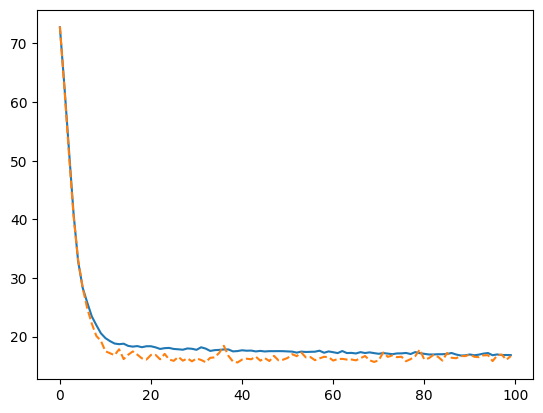

In [88]:
plt.plot(range(100),history.history['MAE'],'-')
plt.plot(range(100), history.history['val_MAE'],'--')
plt.show()